## Import libraries

In [1]:
import gc
import numpy as np
import pandas as pd
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.layers import Activation, Input
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Bidirectional, Dropout
from tensorflow.keras.layers import LSTM, Conv1D, Concatenate
from tensorflow.keras.layers import Flatten, SpatialDropout1D

## Prepare data for model training

In [2]:
train_df = pd.read_csv("../input/tabular-playground-series-jun-2021/train.csv")
train_df['target'] = train_df['target'].apply(lambda x: int(x.replace("Class_","")))
train_df['target'] = train_df['target'].apply(lambda x: 0 if x==9 else x)
train_df.set_index("id", inplace=True)
train_df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,target
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,6,1,0,0,0,0,7,0,...,0,0,0,0,0,0,2,0,0,6
1,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,1,0,6
2,0,0,0,0,0,1,0,3,0,0,...,0,0,0,0,1,0,0,0,0,2
3,0,0,7,0,1,5,2,2,0,1,...,0,4,0,2,2,0,4,3,0,8
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [3]:
test_df = pd.read_csv("../input/tabular-playground-series-jun-2021/test.csv")
test_df.set_index("id", inplace=True)
test_df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74
id,,,,,,,,,,,,,,,,,,,,,
200000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
200001,1,2,0,0,0,0,0,0,0,0,...,3,1,3,0,0,0,0,3,0,0
200002,0,1,7,1,0,0,0,0,6,0,...,3,0,0,0,0,3,0,2,0,0
200003,0,0,0,4,3,1,0,0,0,0,...,0,0,0,1,0,0,0,4,0,0
200004,0,0,5,0,0,0,0,0,0,8,...,0,0,0,0,0,0,0,0,1,0


In [4]:
Xtrain = train_df.loc[:, train_df.columns != 'target'].copy()
Ytrain = train_df['target'].copy()
Ytrain_oh = pd.get_dummies(train_df['target']).copy()
Xtest = test_df.copy()

print("Xtrain: {} \nYtrain: {} \nYtrain_oh: {} \nXtest: {}".format(Xtrain.shape, Ytrain.shape, 
                                                                   Ytrain_oh.shape, Xtest.shape))

del train_df
del test_df
gc.collect()

Xtrain: (200000, 75) 
Ytrain: (200000,) 
Ytrain_oh: (200000, 9) 
Xtest: (100000, 75)


62

## Define TPU config

In [5]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    mini_batch_size = strategy.num_replicas_in_sync * 32
    print("Running on TPU:", tpu.master())
    print(f'batch size: {mini_batch_size}')
    
except ValueError:
    strategy = tf.distribute.get_strategy()
    mini_batch_size = 256
    print(f"Running on {strategy.num_replicas_in_sync} replicas")
    print(f'batch size: {mini_batch_size}')

Running on TPU: grpc://10.0.0.2:8470
batch size: 256


## Build the model

In [6]:
def dnn_model(n_features):
    
    x_input = Input(shape=(n_features,))
    
    x = Embedding(512, 128, trainable=False)(x_input)
    
    embed = Embedding(input_dim=384, output_dim=12, 
                      embeddings_initializer='lecun_normal')(x_input)
    embed = LayerNormalization(epsilon=1e-5)(embed)
    
    x1 = Bidirectional(LSTM(units=12, activation='tanh',
                            return_sequences=True, dropout=0.15,
                            kernel_regularizer=l2(0.0001),
                            kernel_initializer='lecun_normal'), 
                       merge_mode='concat')(embed)
    x1 = LayerNormalization(epsilon=1e-5)(x1)
    
    x2 = Conv1D(filters=24, kernel_size=5, 
                strides=2, padding='same', 
                kernel_regularizer=l2(0.0003), 
                kernel_initializer='lecun_normal')(x1)
    x2 = LayerNormalization(epsilon=1e-5)(x2)
    x2 = Activation('relu')(x2)
    x2 = SpatialDropout1D(rate=0.2)(x2)
    
    lstm_fet = Flatten()(x1)
    conv_fet = Flatten()(x2)
    
    x = Dense(units=32, kernel_initializer='he_uniform', 
                kernel_regularizer=l2(0.0001))(conv_fet)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(rate=0.15)(x)
    
    x = Concatenate()([x, lstm_fet])
    x = BatchNormalization()(x)
    x = Dropout(rate=0.15)(x)
    
    x = Dense(units=32, kernel_initializer='he_uniform', 
                kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(rate=0.15)(x)
    
    x = Concatenate()([x, conv_fet])
    x = BatchNormalization()(x)
    x = Dropout(rate=0.15)(x)
    
    x = Dense(units=16, kernel_initializer='he_uniform', 
                kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(rate=0.15)(x)

    x_output = Dense(units=9, activation='softmax', 
                     kernel_initializer='he_uniform')(x)

    model = Model(inputs=x_input, outputs=x_output, 
                  name='DNN_Model')
    return model

In [7]:
model = dnn_model(Xtrain.shape[1])
model.summary()

Model: "DNN_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 75)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 75, 12)       4608        input_1[0][0]                    
__________________________________________________________________________________________________
layer_normalization (LayerNorma (None, 75, 12)       24          embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 75, 24)       2400        layer_normalization[0][0]        
__________________________________________________________________________________________

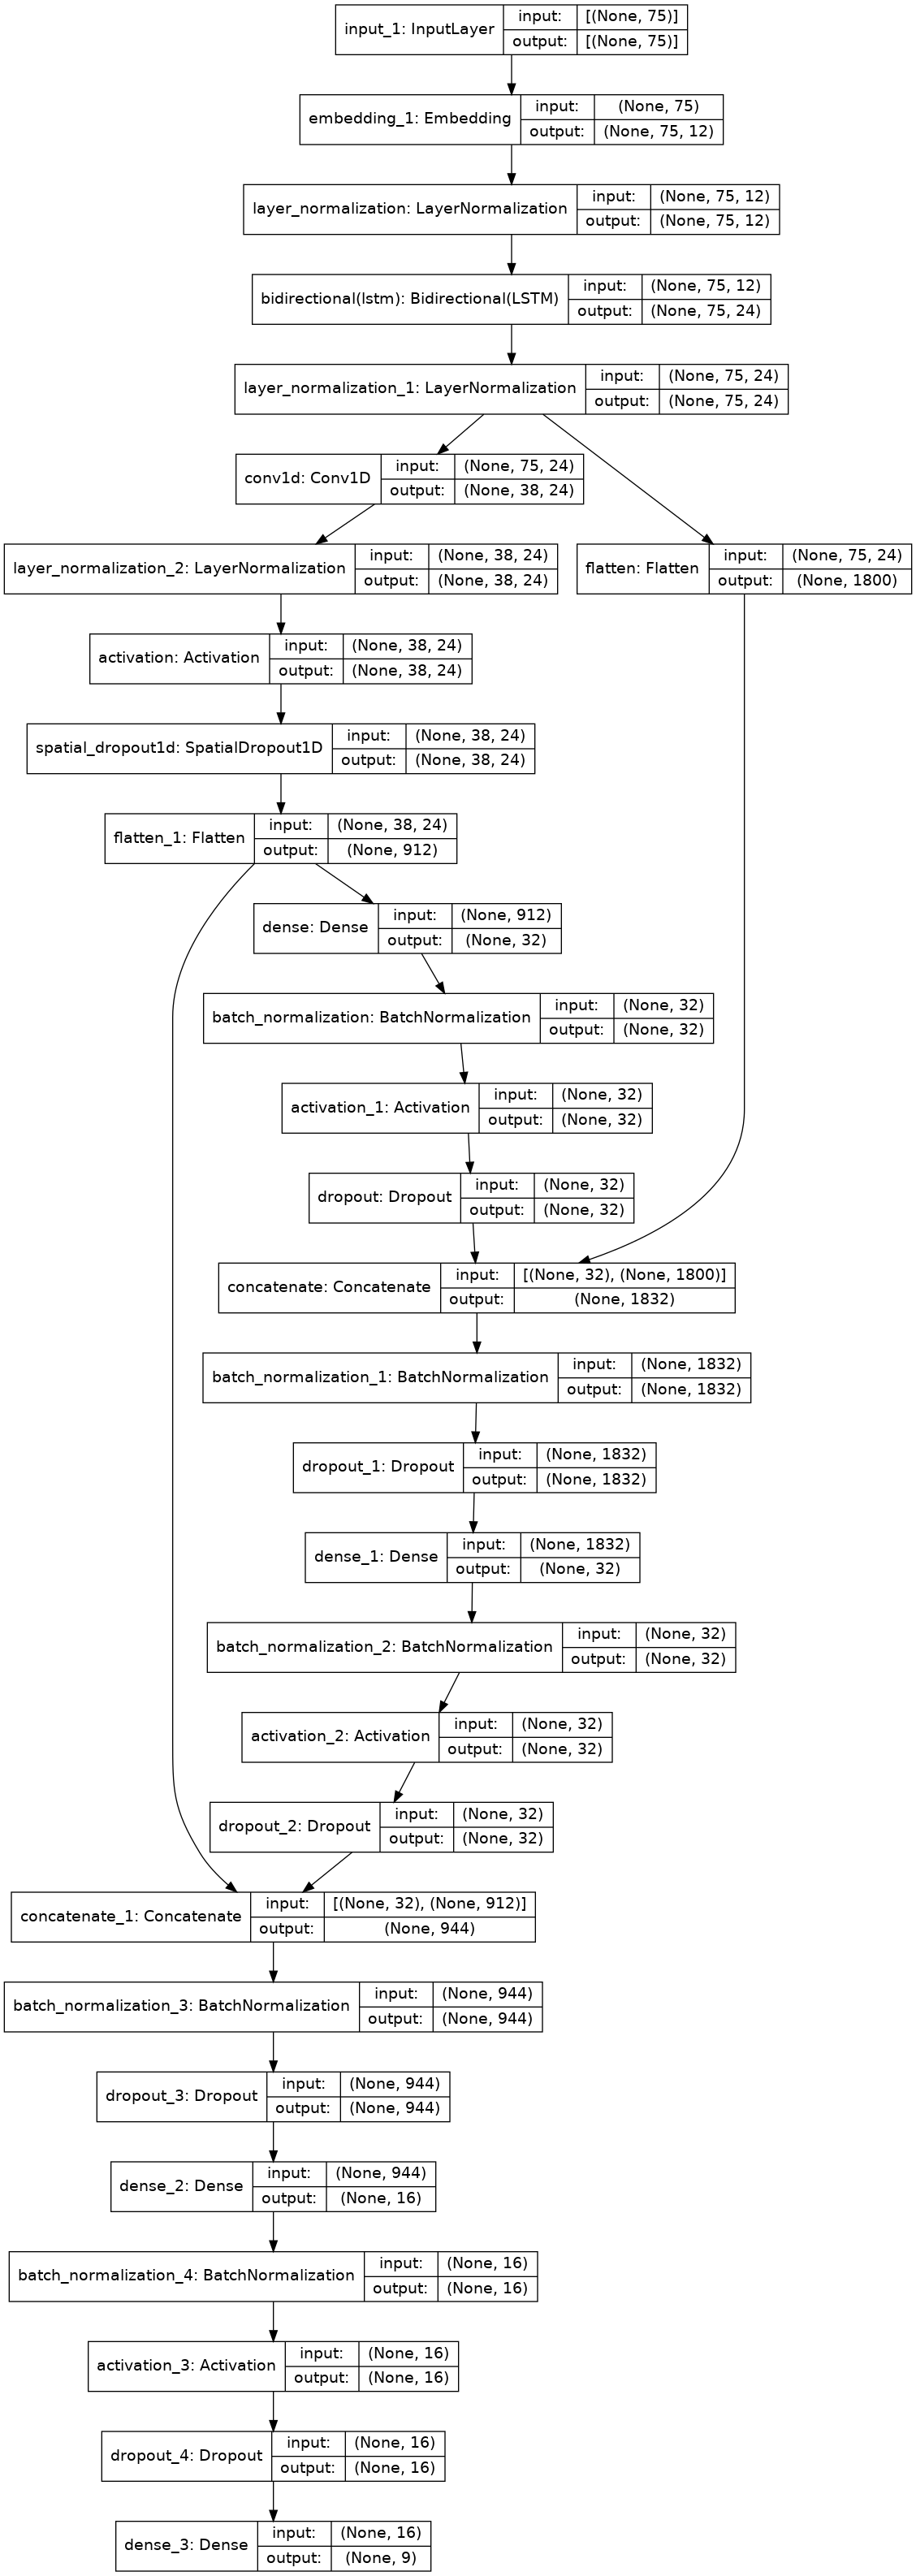

In [8]:
plot_model(
    model, to_file='./DNN_Model.png', 
    show_shapes=True, show_layer_names=True
)

In [9]:
FOLD = 20
NUM_SEED = 2
VERBOSE = 0

np.random.seed(3)
seeds = np.random.randint(0, 100, size=NUM_SEED)

counter = 0
oof_score = 0
y_pred_meta_dnn = np.zeros((Xtrain.shape[0], 9))
y_pred_final_dnn = np.zeros((Xtest.shape[0], 9))

In [10]:
with strategy.scope():
    
    for sidx, seed in enumerate(seeds):
        seed_score = 0

        kfold = StratifiedKFold(n_splits=FOLD, shuffle=True, random_state=seed)

        for idx, (train, val) in enumerate(kfold.split(Xtrain, Ytrain)):
            counter += 1

            train_x, train_y, train_y_oh = Xtrain.iloc[train], Ytrain.iloc[train], Ytrain_oh.iloc[train]
            val_x, val_y, val_y_oh = Xtrain.iloc[val], Ytrain.iloc[val], Ytrain_oh.iloc[val]
            
            tf.random.set_seed(seed+idx)

            model = dnn_model(Xtrain.shape[1])
            model.compile(loss='categorical_crossentropy',
                          optimizer=Adamax(lr=8e-3))

            early = EarlyStopping(monitor="val_loss", mode="min", 
                                  restore_best_weights=True, 
                                  patience=7, verbose=VERBOSE)

            reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.25, 
                                          min_lr=1e-6, patience=3, 
                                          verbose=VERBOSE, mode='min')

            chk_point = ModelCheckpoint(f'./DNN_model_{counter}C.h5', 
                                        monitor='val_loss', verbose=VERBOSE, 
                                        save_best_only=True, mode='min', 
                                        save_weights_only=True)

            history = model.fit(
                train_x, train_y_oh, 
                batch_size=mini_batch_size,
                epochs=100, 
                verbose=VERBOSE, 
                callbacks=[reduce_lr, early, chk_point], 
                validation_data=(val_x, val_y_oh)
            )

            model.load_weights(f'./DNN_model_{counter}C.h5')

            y_pred = model.predict(val_x)
            y_pred_meta_dnn[val] += y_pred
            y_pred_final_dnn += model.predict(Xtest)

            score = log_loss(val_y_oh, y_pred)
            oof_score += score
            seed_score += score
            print("Seed-{} | Fold-{} | OOF Score: {}".format(seed, idx, score))

        print("\nSeed: {} | Aggregate OOF Score: {}\n\n".format(seed, (seed_score / FOLD)))

Seed-24 | Fold-0 | OOF Score: 1.7422233522888273
Seed-24 | Fold-1 | OOF Score: 1.7464898296885192
Seed-24 | Fold-2 | OOF Score: 1.7414131354086102
Seed-24 | Fold-3 | OOF Score: 1.746616994418949
Seed-24 | Fold-4 | OOF Score: 1.7361841906562447
Seed-24 | Fold-5 | OOF Score: 1.745478192645684
Seed-24 | Fold-6 | OOF Score: 1.7452026483891532
Seed-24 | Fold-7 | OOF Score: 1.747016401635669
Seed-24 | Fold-8 | OOF Score: 1.7385323700314388
Seed-24 | Fold-9 | OOF Score: 1.7398064923425205
Seed-24 | Fold-10 | OOF Score: 1.7440483424939215
Seed-24 | Fold-11 | OOF Score: 1.734914569259435
Seed-24 | Fold-12 | OOF Score: 1.7454330688787625
Seed-24 | Fold-13 | OOF Score: 1.738353999513574
Seed-24 | Fold-14 | OOF Score: 1.7432932511523367
Seed-24 | Fold-15 | OOF Score: 1.7393903458483517
Seed-24 | Fold-16 | OOF Score: 1.745422787494678
Seed-24 | Fold-17 | OOF Score: 1.744229201706592
Seed-24 | Fold-18 | OOF Score: 1.7413572892365978
Seed-24 | Fold-19 | OOF Score: 1.749144845767319

Seed: 24 | Aggreg

In [11]:
y_pred_meta_dnn = y_pred_meta_dnn / float(NUM_SEED)
y_pred_final_dnn = y_pred_final_dnn / float(counter)
oof_score /= float(counter)
print("Aggregate OOF Score: {}".format(oof_score))

Aggregate OOF Score: 1.7428022630183613


In [12]:
np.savez_compressed('./DNN_Meta_Features.npz',
                    y_pred_meta_dnn=y_pred_meta_dnn, 
                    oof_score=oof_score,
                    y_pred_final_dnn=y_pred_final_dnn)

## Create submission file

In [13]:
test_df = pd.read_csv("../input/tabular-playground-series-jun-2021/test.csv")
submit_df = pd.DataFrame()
submit_df['id'] = test_df['id']
submit_df['Class_1'] = y_pred_final_dnn[:,1]
submit_df['Class_2'] = y_pred_final_dnn[:,2]
submit_df['Class_3'] = y_pred_final_dnn[:,3]
submit_df['Class_4'] = y_pred_final_dnn[:,4]
submit_df['Class_5'] = y_pred_final_dnn[:,5]
submit_df['Class_6'] = y_pred_final_dnn[:,6]
submit_df['Class_7'] = y_pred_final_dnn[:,7]
submit_df['Class_8'] = y_pred_final_dnn[:,8]
submit_df['Class_9'] = y_pred_final_dnn[:,0]
submit_df.to_csv("./DNN_submission.csv", index=False)
submit_df.head()

,id,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,200000,0.065861,0.420856,0.158144,0.027026,0.012708,0.132138,0.020025,0.042538,0.120705
1,200001,0.042775,0.076108,0.058755,0.022669,0.015305,0.276025,0.083807,0.289882,0.134674
2,200002,0.016984,0.025048,0.016040,0.008769,0.005199,0.766849,0.022864,0.098189,0.040058
3,200003,0.046799,0.131585,0.090797,0.029841,0.018577,0.230264,0.076476,0.218392,0.157269
4,200004,0.041593,0.111449,0.079302,0.025090,0.015581,0.266577,0.074193,0.240252,0.145964
